# Various linear regressions using extracted features

In this notebook, we investigate which of our extracted features may be useful in an attempt to find a model. Unfortunately, linear regression did not appear to help. 

In [589]:
# import modules
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor

# Loss Function

In [590]:
# Various useful functions

def get_mae(az_true, zen_true, az_pred, zen_pred): 
    """
    Given a predicted and true azimuth and zenith, compute the mae (mean angular error)
    """    
    if not (np.all(np.isfinite(az_true)) and
            np.all(np.isfinite(zen_true)) and
            np.all(np.isfinite(az_pred)) and
            np.all(np.isfinite(zen_pred))):
        raise ValueError("All arguments must be finite")
    
    # pre-compute all sine and cosine values
    sa1 = np.sin(az_true)
    ca1 = np.cos(az_true)
    sz1 = np.sin(zen_true)
    cz1 = np.cos(zen_true)
    
    sa2 = np.sin(az_pred)
    ca2 = np.cos(az_pred)
    sz2 = np.sin(zen_pred)
    cz2 = np.cos(zen_pred)
    
    # scalar product of the two cartesian vectors (x = sz*ca, y = sz*sa, z = cz)
    scalar_prod = sz1*sz2*(ca1*ca2 + sa1*sa2) + (cz1*cz2)
    
    # scalar product of two unit vectors is always between -1 and 1, this is against nummerical instability
    # that might otherwise occure from the finite precision of the sine and cosine functions
    scalar_prod =  np.clip(scalar_prod, -1, 1)
    
    # convert back to an angle (in radian)
    return np.average(np.abs(np.arccos(scalar_prod)))

def mae(y_true, y_pred): 
    return get_mae(y_true[0], y_true[1], y_pred[0], y_pred[1])

def get_maes(y_pred, y_true): 
    """
    Given a list of predictions and true values of azimuth and zenith, compute mae
    """
    n = len(y_pred)
    maes = np.zeros(n)
    for i in range (0,n):
        az_true = y_true[i][0]
        ze_true = y_true[i][1]
        az_pred = y_pred[i][0]
        ze_pred = y_pred[i][1]
        mae = get_mae(az_true, ze_true, az_pred, ze_pred)
        maes[i] = mae
        
    return maes.mean()

# Format data

In [591]:
# Read data
event_data = pd.read_csv("C:/Users/k_vsl/Documents/Erdos/Boot Camp/ice-cube-katja/features-final.csv")

In [592]:
event_data.columns

Index(['event_id', 'vx_t', 'vy_t', 'vz_t', 'az_t_pred', 'ze_t_pred', 'mae_t',
       'mse_squared', 'mse', 'vx_pca', 'vy_pca', 'vz_pca', 'az_pca_pred',
       'ze_pca_pred', 'az_true', 'ze_true', 'num_clusters', 'dot_product',
       'mse_cat', 'cat_1.0', 'cat_2.0', 'cat_3.0', 'cat_4.0', 'cat_5.0',
       'cat_6.0', 'cat_7.0', 'cat_8.0', 'cat_9.0', 'cat_10.0', 'cat_11.0',
       'per_x', 'per_y', 'per_z', 'cat_x', 'cat_y', 'cat_z'],
      dtype='object')

In [593]:
# Separate training parameters into features and output
X = event_data
X = X.set_index("event_id")
y = event_data[['event_id', 'az_true', 'ze_true']]
y = y.set_index("event_id")

In [594]:
# Separate out a final training set
# random seed = 134
# test size = 25%
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                             shuffle = True,
                                                             random_state = 134, 
                                                             test_size = .25)

In [595]:
# k-fold cross validation
# this cell imitates the erdos lectures notes on kfold cross validation , k = 5
# random seed to all splits random_seed = 134
kfold = KFold(n_splits = 5,
             shuffle = True,
             random_state = 134)

# Helper Functions to run multiple regressions

In [596]:
# Function to run sklearn Linear Regression
def run_lr(V, w, features): 
    V_train = V[features]
    w_train = w
    
    i = 0
    maes = np.zeros(5)
    
    for train_index, test_index in kfold.split(V_train, w_train):
        ## get the kfold training data
        V_train_train = V_train.iloc[train_index,:]
        w_train_train = w_train.iloc[train_index]
    
        ## get the holdout data
        V_holdout = V_train.iloc[test_index,:]
        w_holdout = w_train.iloc[test_index]
        
        lr = LinearRegression(copy_X = True)
        lr.fit(V_train_train, w_train_train)
        # Toggle on and off to see coefficients
        # print(lr.coef_)
        w_pred = lr.predict(V_holdout)
        mae = get_maes(w_pred, w_holdout.values)   
        maes[i] = mae
        i += 1
    
    return maes.mean()

In [597]:
# Function to run sklearn SGDRegression with epsilon_insensitive
def run_sgd(V, w, features, loss_fun): 
    
    V_train = V[features]
    w_train_az = w['az_true']
    w_train_ze = w['ze_true']
    
    i = 0
    maes = np.zeros(5)
    
    for train_index, test_index in kfold.split(V_train, w_train_az):
        ## get the kfold training data
        V_train_train = V_train.iloc[train_index,:]
        w_train_train_az = w_train_az.iloc[train_index]
        w_train_train_ze = w_train_ze.iloc[train_index]
    
        ## get the holdout data
        V_holdout = V_train.iloc[test_index,:]
        w_holdout_az = w_train_az.iloc[test_index]
        w_holdout_ze = w_train_ze.iloc[test_index]
        
        model_az = SGDRegressor(loss = loss_fun, max_iter = 50000)
        model_ze = SGDRegressor(loss = loss_fun, max_iter = 50000)
        model_az.fit(V_train_train, w_train_train_az)
        model_ze.fit(V_train_train, w_train_train_ze)
        w_pred_az = model_az.predict(V_holdout)
        w_pred_ze = model_ze.predict(V_holdout)
        w_pred = np.zeros((len(w_holdout_az), 2))
        w_true = np.zeros((len(w_holdout_ze), 2))
        w_pred[:,0] = w_pred_az
        w_pred[:,1] = w_pred_ze
        w_true[:,0] = w_holdout_az
        w_true[:,1] = w_holdout_ze
        mae = get_maes(w_pred, w_true) 
    
        maes[i] = mae
        i += 1
    
    return maes.mean()

# Model 1: Baseline

In [598]:
# Model 1: No Linear Regression
# Just use the time best fit line and average the mae's from the line itself
X_mae = X_train['mae_t']
y_mae = y_train
maes = np.zeros(5)
i = 0
for train_index, test_index in kfold.split(X_mae, y_mae): 
    X_holdout = X_mae.iloc[test_index]
    maes[i] = X_holdout.mean()
    i += 1
print("Model 1: " + str(maes.mean()))

Model 1: 1.2137944928512907


Model 1 has k-fold mae: 1.2137944928512907

# Base Linear Regression Models

In [599]:
# Linear Regression models
features = [['az_t_pred', 'ze_t_pred'], 
            ['az_t_pred', 'ze_t_pred', 'num_clusters'], 
            ['az_t_pred', 'ze_t_pred', 'mse'], 
            ['az_t_pred', 'ze_t_pred', 'dot_product'], 
            ['az_t_pred', 'ze_t_pred', 'az_pca_pred', 'ze_pca_pred'], 
            ['az_t_pred', 'ze_t_pred', 'mse_cat'], 
            ['az_pca_pred', 'ze_pca_pred'],
            ['az_t_pred', 'ze_t_pred','cat_1.0','cat_2.0', 'cat_3.0', 'cat_4.0', 'cat_5.0', 'cat_6.0', 'cat_7.0','cat_8.0', 'cat_9.0', 'cat_10.0'], 
            ['az_t_pred', 'ze_t_pred', 'cat_x', 'cat_y', 'cat_z', 'mse', 'cat_1.0','cat_2.0', 'cat_3.0', 'cat_4.0', 'cat_5.0', 'cat_6.0', 'cat_7.0','cat_8.0', 'cat_9.0', 'cat_10.0'], 
            ['az_t_pred', 'ze_t_pred', 'cat_x', 'cat_y', 'cat_z', 'mse_cat', 'cat_1.0','cat_2.0', 'cat_3.0', 'cat_4.0', 'cat_5.0', 'cat_6.0', 'cat_7.0','cat_8.0', 'cat_9.0', 'cat_10.0']
        ]


n = len(features)
maes = np.zeros(n)

i = 0
for i in range(0,n):
    mae = run_lr(X_train, y_train, features[i])
    maes[i] = mae
    print("Using features: " + str(features[i]) + ", the MAE is " + str(mae))
    i += 1


Using features: ['az_t_pred', 'ze_t_pred'], the MAE is 1.5114392346721135
Using features: ['az_t_pred', 'ze_t_pred', 'num_clusters'], the MAE is 1.5091467497314988
Using features: ['az_t_pred', 'ze_t_pred', 'mse'], the MAE is 1.5100998640596575
Using features: ['az_t_pred', 'ze_t_pred', 'dot_product'], the MAE is 1.5096530615494284
Using features: ['az_t_pred', 'ze_t_pred', 'az_pca_pred', 'ze_pca_pred'], the MAE is 1.5105590649667482
Using features: ['az_t_pred', 'ze_t_pred', 'mse_cat'], the MAE is 1.5094332297633348
Using features: ['az_pca_pred', 'ze_pca_pred'], the MAE is 1.5219531894197487
Using features: ['az_t_pred', 'ze_t_pred', 'cat_1.0', 'cat_2.0', 'cat_3.0', 'cat_4.0', 'cat_5.0', 'cat_6.0', 'cat_7.0', 'cat_8.0', 'cat_9.0', 'cat_10.0'], the MAE is 1.507800883963829
Using features: ['az_t_pred', 'ze_t_pred', 'cat_x', 'cat_y', 'cat_z', 'mse', 'cat_1.0', 'cat_2.0', 'cat_3.0', 'cat_4.0', 'cat_5.0', 'cat_6.0', 'cat_7.0', 'cat_8.0', 'cat_9.0', 'cat_10.0'], the MAE is 1.5067696839319

Best k-fold mae comes from features: 
['az_t_pred', 'ze_t_pred', 'cat_x', 'cat_y', 'cat_z', 'mse_cat', 'cat_1.0', 'cat_2.0', 'cat_3.0', 'cat_4.0', 'cat_5.0', 'cat_6.0', 'cat_7.0', 'cat_8.0', 'cat_9.0', 'cat_10.0']
Value: 1.5064680472951655

In [600]:
# SGDRegression with loss = 'epsilon_insensitive'

features = [['az_t_pred', 'ze_t_pred'], 
            ['az_t_pred', 'ze_t_pred', 'num_clusters'], 
            ['az_t_pred', 'ze_t_pred', 'mse'], 
            ['az_t_pred', 'ze_t_pred', 'dot_product'], 
            ['az_t_pred', 'ze_t_pred', 'az_pca_pred', 'ze_pca_pred'], 
            ['az_t_pred', 'ze_t_pred', 'mse_cat'], 
            ['az_pca_pred', 'ze_pca_pred'],
            ['az_t_pred', 'ze_t_pred','cat_1.0','cat_2.0', 'cat_3.0', 'cat_4.0', 'cat_5.0', 'cat_6.0', 'cat_7.0','cat_8.0', 'cat_9.0', 'cat_10.0'], 
            ['az_t_pred', 'ze_t_pred', 'cat_x', 'cat_y', 'cat_z', 'mse', 'cat_1.0','cat_2.0', 'cat_3.0', 'cat_4.0', 'cat_5.0', 'cat_6.0', 'cat_7.0','cat_8.0', 'cat_9.0', 'cat_10.0'], 
            ['az_t_pred', 'ze_t_pred', 'cat_x', 'cat_y', 'cat_z', 'mse_cat', 'cat_1.0','cat_2.0', 'cat_3.0', 'cat_4.0', 'cat_5.0', 'cat_6.0', 'cat_7.0','cat_8.0', 'cat_9.0', 'cat_10.0']
        ]



n = len(features)
maes_sgd = np.zeros(n)

i = 0
for i in range(0,n):
    mae = run_sgd(X_train, y_train, features[i], 'epsilon_insensitive')
    maes_sgd[i] = mae
    print("Using features: " + str(features[i]) + ", the MAE is " + str(mae))
    i += 1

Using features: ['az_t_pred', 'ze_t_pred'], the MAE is 1.4618878946957579
Using features: ['az_t_pred', 'ze_t_pred', 'num_clusters'], the MAE is 1.4557881752583124
Using features: ['az_t_pred', 'ze_t_pred', 'mse'], the MAE is 1.5743695565091955
Using features: ['az_t_pred', 'ze_t_pred', 'dot_product'], the MAE is 1.4603143893595898
Using features: ['az_t_pred', 'ze_t_pred', 'az_pca_pred', 'ze_pca_pred'], the MAE is 1.466331498919548
Using features: ['az_t_pred', 'ze_t_pred', 'mse_cat'], the MAE is 1.4567743744906714
Using features: ['az_pca_pred', 'ze_pca_pred'], the MAE is 1.4812092394751233
Using features: ['az_t_pred', 'ze_t_pred', 'cat_1.0', 'cat_2.0', 'cat_3.0', 'cat_4.0', 'cat_5.0', 'cat_6.0', 'cat_7.0', 'cat_8.0', 'cat_9.0', 'cat_10.0'], the MAE is 1.4577674734067174
Using features: ['az_t_pred', 'ze_t_pred', 'cat_x', 'cat_y', 'cat_z', 'mse', 'cat_1.0', 'cat_2.0', 'cat_3.0', 'cat_4.0', 'cat_5.0', 'cat_6.0', 'cat_7.0', 'cat_8.0', 'cat_9.0', 'cat_10.0'], the MAE is 1.5748026707150

Best k-fold mae comes from features: 
['az_t_pred', 'ze_t_pred', 'cat_x', 'cat_y', 'cat_z', 'mse_cat', 'cat_1.0', 'cat_2.0', 'cat_3.0', 'cat_4.0', 'cat_5.0', 'cat_6.0', 'cat_7.0', 'cat_8.0', 'cat_9.0', 'cat_10.0']
Value: 1.4511509147669819

In [601]:
# SGDRegression with loss = 'huber'

features = [['az_t_pred', 'ze_t_pred'], 
            ['az_t_pred', 'ze_t_pred', 'num_clusters'], 
            ['az_t_pred', 'ze_t_pred', 'mse'], 
            ['az_t_pred', 'ze_t_pred', 'dot_product'], 
            ['az_t_pred', 'ze_t_pred', 'az_pca_pred', 'ze_pca_pred'], 
            ['az_t_pred', 'ze_t_pred', 'mse_cat'], 
            ['az_pca_pred', 'ze_pca_pred'],
            ['az_t_pred', 'ze_t_pred','cat_1.0','cat_2.0', 'cat_3.0', 'cat_4.0', 'cat_5.0', 'cat_6.0', 'cat_7.0','cat_8.0', 'cat_9.0', 'cat_10.0'], 
            ['az_t_pred', 'ze_t_pred', 'cat_x', 'cat_y', 'cat_z', 'mse', 'cat_1.0','cat_2.0', 'cat_3.0', 'cat_4.0', 'cat_5.0', 'cat_6.0', 'cat_7.0','cat_8.0', 'cat_9.0', 'cat_10.0'], 
            ['az_t_pred', 'ze_t_pred', 'cat_x', 'cat_y', 'cat_z', 'mse_cat', 'cat_1.0','cat_2.0', 'cat_3.0', 'cat_4.0', 'cat_5.0', 'cat_6.0', 'cat_7.0','cat_8.0', 'cat_9.0', 'cat_10.0']
        ]


n = len(features)
maes_sgdh = np.zeros(n)

i = 0
for i in range(0,n):
    mae = run_sgd(X_train, y_train, features[i], 'huber')
    maes_sgdh[i] = mae
    print("Using features: " + str(features[i]) + ", the MAE is " + str(mae))
    i += 1

Using features: ['az_t_pred', 'ze_t_pred'], the MAE is 1.4566696024827528
Using features: ['az_t_pred', 'ze_t_pred', 'num_clusters'], the MAE is 1.4501782143801938
Using features: ['az_t_pred', 'ze_t_pred', 'mse'], the MAE is 1.5772359830142508
Using features: ['az_t_pred', 'ze_t_pred', 'dot_product'], the MAE is 1.457254319227922
Using features: ['az_t_pred', 'ze_t_pred', 'az_pca_pred', 'ze_pca_pred'], the MAE is 1.455977078537934
Using features: ['az_t_pred', 'ze_t_pred', 'mse_cat'], the MAE is 1.4529140703749999
Using features: ['az_pca_pred', 'ze_pca_pred'], the MAE is 1.478973825824332
Using features: ['az_t_pred', 'ze_t_pred', 'cat_1.0', 'cat_2.0', 'cat_3.0', 'cat_4.0', 'cat_5.0', 'cat_6.0', 'cat_7.0', 'cat_8.0', 'cat_9.0', 'cat_10.0'], the MAE is 1.4511278581810632
Using features: ['az_t_pred', 'ze_t_pred', 'cat_x', 'cat_y', 'cat_z', 'mse', 'cat_1.0', 'cat_2.0', 'cat_3.0', 'cat_4.0', 'cat_5.0', 'cat_6.0', 'cat_7.0', 'cat_8.0', 'cat_9.0', 'cat_10.0'], the MAE is 1.560045171605290

In [ ]:
Best k-fold mae comes from features: 
['az_t_pred', 'ze_t_pred', 'cat_x', 'cat_y', 'cat_z', 'mse_cat', 'cat_1.0', 'cat_2.0', 'cat_3.0', 'cat_4.0', 'cat_5.0', 'cat_6.0', 'cat_7.0', 'cat_8.0', 'cat_9.0', 'cat_10.0']
Value: 1.4459629108551826

# Tune features
Since the categorical variables were useful, let's tune them slightly for various cutoffs and attempt to reduce the number of categorical variables by classifying clusters as low, medium, high

In [ ]:
# Get coefficients for original good models to get an idea of what reasonable cluster cutoffs could be
features = ['az_t_pred', 'ze_t_pred', 'cat_x', 'cat_y', 'cat_z', 'mse_cat', 'cat_1.0','cat_2.0', 'cat_3.0', 'cat_4.0', 'cat_5.0', 'cat_6.0', 'cat_7.0','cat_8.0', 'cat_9.0', 'cat_10.0']
mae = run_lr(X_train, y_train, features)

In [602]:
# Tune cutoffs for skews with cluster cutoffs 4 and 7
print("Running")
cutoffs = np.arange(.5, 1, .05)
n = len(cutoffs)
maes_lr = np.zeros(n)
maes_h = np.zeros(n)
i = 0
for i in range(0,n): 
    cutoff = cutoffs[i]
    print("The cutoff is " + str(cutoff))
    V = X[['az_t_pred', 'ze_t_pred', 'num_clusters','mse_cat','per_x', 'per_y', 'per_z']]
    V['x_skew'] = [(val > cutoff) for val in V.per_x]
    V['y_skew'] = [(val > cutoff) for val in V.per_y]
    V['z_skew'] = [(val > cutoff) for val in V.per_z]
    V['low_cluster'] = [(c < 4) for c in V.num_clusters]
    V['high_cluster'] = [(c >= 8) for c in V.num_clusters]
    V.replace({False: 0, True: 1}, inplace=True)
    
    V_train, V_val, y_train, y_val = train_test_split(V, y, 
                                                             shuffle = True,
                                                             random_state = 134, 
                                                             test_size = .25)
    feature = ['az_t_pred', 'ze_t_pred', 'x_skew', 'y_skew', 'z_skew', 'mse_cat', 'low_cluster', 'high_cluster']
    mae_lr = run_lr(V_train, y_train, feature)
    mae_h = run_sgd(V_train, y_train, feature, 'huber')
    maes_lr[i] = mae_lr
    maes_h[i] = mae_h
    print("The linear regression mae is " + str(mae_lr))
    print("The huber regression mae is " + str(mae_h))
    i += 1

Running
The cutoff is 0.5


C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1176702385.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['x_skew'] = [(val > cutoff) for val in V.per_x]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1176702385.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['y_skew'] = [(val > cutoff) for val in V.per_y]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1176702385.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

The linear regression mae is 1.508651054534671
The huber regression mae is 1.4491486596684073
The cutoff is 0.55


C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1176702385.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['x_skew'] = [(val > cutoff) for val in V.per_x]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1176702385.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['y_skew'] = [(val > cutoff) for val in V.per_y]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1176702385.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

The linear regression mae is 1.5086545320799822
The huber regression mae is 1.4491314797005057
The cutoff is 0.6000000000000001


C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1176702385.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['x_skew'] = [(val > cutoff) for val in V.per_x]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1176702385.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['y_skew'] = [(val > cutoff) for val in V.per_y]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1176702385.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

The linear regression mae is 1.5086410947642679
The huber regression mae is 1.4502039169873284
The cutoff is 0.6500000000000001


C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1176702385.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['x_skew'] = [(val > cutoff) for val in V.per_x]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1176702385.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['y_skew'] = [(val > cutoff) for val in V.per_y]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1176702385.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

The linear regression mae is 1.5085738058788245
The huber regression mae is 1.4489026860837613
The cutoff is 0.7000000000000002


C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1176702385.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['x_skew'] = [(val > cutoff) for val in V.per_x]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1176702385.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['y_skew'] = [(val > cutoff) for val in V.per_y]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1176702385.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

The linear regression mae is 1.5085254238604633
The huber regression mae is 1.4484286511643447
The cutoff is 0.7500000000000002


C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1176702385.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['x_skew'] = [(val > cutoff) for val in V.per_x]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1176702385.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['y_skew'] = [(val > cutoff) for val in V.per_y]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1176702385.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

The linear regression mae is 1.508378976015092
The huber regression mae is 1.449504454859626
The cutoff is 0.8000000000000003


C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1176702385.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['x_skew'] = [(val > cutoff) for val in V.per_x]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1176702385.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['y_skew'] = [(val > cutoff) for val in V.per_y]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1176702385.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

The linear regression mae is 1.5082524414724656
The huber regression mae is 1.4481613231424049
The cutoff is 0.8500000000000003


C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1176702385.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['x_skew'] = [(val > cutoff) for val in V.per_x]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1176702385.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['y_skew'] = [(val > cutoff) for val in V.per_y]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1176702385.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

The linear regression mae is 1.5080094872742822
The huber regression mae is 1.448532162388818
The cutoff is 0.9000000000000004


C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1176702385.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['x_skew'] = [(val > cutoff) for val in V.per_x]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1176702385.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['y_skew'] = [(val > cutoff) for val in V.per_y]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1176702385.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

The linear regression mae is 1.5077816036883729
The huber regression mae is 1.448053028077291
The cutoff is 0.9500000000000004


C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1176702385.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['x_skew'] = [(val > cutoff) for val in V.per_x]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1176702385.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['y_skew'] = [(val > cutoff) for val in V.per_y]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1176702385.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

The linear regression mae is 1.50744727457383
The huber regression mae is 1.447934764357909


In [603]:
print(maes_lr)
print(maes_h)
print(cutoffs)

[1.50865105 1.50865453 1.50864109 1.50857381 1.50852542 1.50837898
 1.50825244 1.50800949 1.5077816  1.50744727]
[1.44914866 1.44913148 1.45020392 1.44890269 1.44842865 1.44950445
 1.44816132 1.44853216 1.44805303 1.44793476]
[0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95]


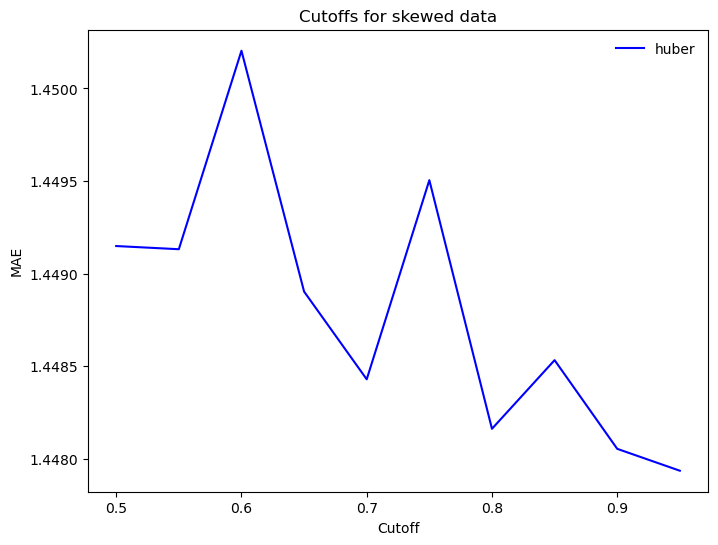

In [613]:
# Graph for different cutoffs
plt.figure(figsize=(8,6))

#plt.plot(cutoffs, maes_lr, label= 'Epsilon Insensitive', c = 'orange')
plt.plot(cutoffs, maes_h, label = 'huber', c = 'blue')
#plt.plot(maes_h, label='huber', c = 'blue')
plt.legend(frameon=False)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel("Cutoff")
plt.ylabel("MAE")
plt.title("Cutoffs for skewed data")

plt.show()

Takeaway: The ideal cutoff appears to be around .95 however, in the spirit of not overfitting, perhaps .9 is better

In [615]:
# Tune cutoffs for skews with cluster cutoffs 3 and 7

print("Running")
cutoffs = np.arange(.5, 1, .05)
n = len(cutoffs)
maes_lr = np.zeros(n)
maes_h = np.zeros(n)
i = 0
for i in range(0,n): 
    cutoff = cutoffs[i]
    print("The cutoff is " + str(cutoff))
    V = X[['az_t_pred', 'ze_t_pred', 'num_clusters','mse_cat','per_x', 'per_y', 'per_z']]
    V['x_skew'] = [(val > cutoff) for val in V.per_x]
    V['y_skew'] = [(val > cutoff) for val in V.per_y]
    V['z_skew'] = [(val > cutoff) for val in V.per_z]
    V['low_cluster'] = [(c < 3) for c in V.num_clusters]
    V['high_cluster'] = [(c >= 8) for c in V.num_clusters]
    V.replace({False: 0, True: 1}, inplace=True)
    
    V_train, V_val, y_train, y_val = train_test_split(V, y, 
                                                             shuffle = True,
                                                             random_state = 134, 
                                                             test_size = .25)
    feature = ['az_t_pred', 'ze_t_pred', 'x_skew', 'y_skew', 'z_skew', 'mse_cat', 'low_cluster', 'high_cluster']
    #mae_lr = run_lr(V_train, y_train, feature)
    mae_h = run_sgd(V_train, y_train, feature, 'huber')
    #maes_lr[i] = mae_lr
    maes_h[i] = mae_h
    print("The linear regression mae is " + str(mae_lr))
    print("The huber regression mae is " + str(mae_h))
    i += 1

Running
The cutoff is 0.5


C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\494964417.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['x_skew'] = [(val > cutoff) for val in V.per_x]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\494964417.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['y_skew'] = [(val > cutoff) for val in V.per_y]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\494964417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The linear regression mae is 1.5082585118844432
The huber regression mae is 1.4477790166708489
The cutoff is 0.55


C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\494964417.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['x_skew'] = [(val > cutoff) for val in V.per_x]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\494964417.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['y_skew'] = [(val > cutoff) for val in V.per_y]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\494964417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The linear regression mae is 1.5082585118844432
The huber regression mae is 1.4491102540207905
The cutoff is 0.6000000000000001


C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\494964417.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['x_skew'] = [(val > cutoff) for val in V.per_x]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\494964417.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['y_skew'] = [(val > cutoff) for val in V.per_y]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\494964417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The linear regression mae is 1.5082585118844432
The huber regression mae is 1.4470535642648972
The cutoff is 0.6500000000000001


C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\494964417.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['x_skew'] = [(val > cutoff) for val in V.per_x]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\494964417.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['y_skew'] = [(val > cutoff) for val in V.per_y]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\494964417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The linear regression mae is 1.5082585118844432
The huber regression mae is 1.4472297440920574
The cutoff is 0.7000000000000002


C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\494964417.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['x_skew'] = [(val > cutoff) for val in V.per_x]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\494964417.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['y_skew'] = [(val > cutoff) for val in V.per_y]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\494964417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The linear regression mae is 1.5082585118844432
The huber regression mae is 1.447457289649631
The cutoff is 0.7500000000000002


C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\494964417.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['x_skew'] = [(val > cutoff) for val in V.per_x]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\494964417.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['y_skew'] = [(val > cutoff) for val in V.per_y]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\494964417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The linear regression mae is 1.5082585118844432
The huber regression mae is 1.446968044606178
The cutoff is 0.8000000000000003


C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\494964417.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['x_skew'] = [(val > cutoff) for val in V.per_x]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\494964417.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['y_skew'] = [(val > cutoff) for val in V.per_y]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\494964417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The linear regression mae is 1.5082585118844432
The huber regression mae is 1.4466636950060718
The cutoff is 0.8500000000000003


C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\494964417.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['x_skew'] = [(val > cutoff) for val in V.per_x]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\494964417.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['y_skew'] = [(val > cutoff) for val in V.per_y]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\494964417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The linear regression mae is 1.5082585118844432
The huber regression mae is 1.4466271198296172
The cutoff is 0.9000000000000004


C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\494964417.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['x_skew'] = [(val > cutoff) for val in V.per_x]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\494964417.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['y_skew'] = [(val > cutoff) for val in V.per_y]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\494964417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The linear regression mae is 1.5082585118844432
The huber regression mae is 1.4467195064155483
The cutoff is 0.9500000000000004


C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\494964417.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['x_skew'] = [(val > cutoff) for val in V.per_x]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\494964417.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['y_skew'] = [(val > cutoff) for val in V.per_y]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\494964417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The linear regression mae is 1.5082585118844432
The huber regression mae is 1.4458851646983752


In [616]:
print(maes_h)
print(cutoffs)

[1.44777902 1.44911025 1.44705356 1.44722974 1.44745729 1.44696804
 1.4466637  1.44662712 1.44671951 1.44588516]
[0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95]


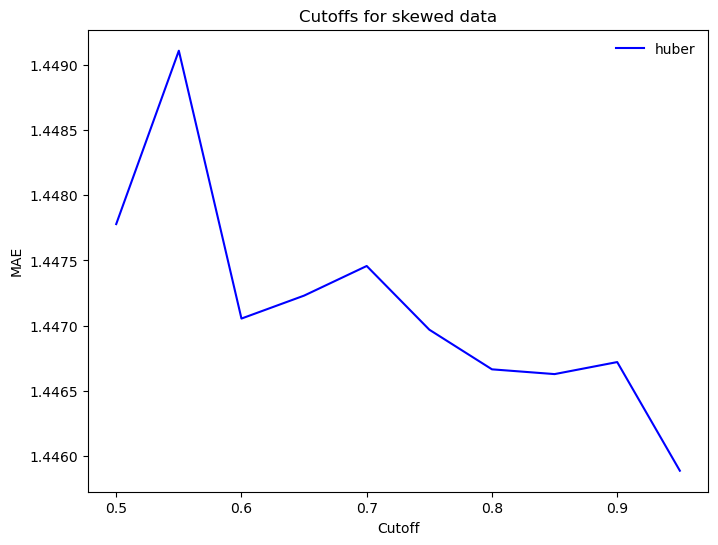

In [617]:
# Graph for different cutoffs
plt.figure(figsize=(8,6))

#plt.plot(cutoffs, maes_lr, label= 'Epsilon Insensitive', c = 'orange')
plt.plot(cutoffs, maes_h, label = 'huber', c = 'blue')
#plt.plot(maes_h, label='huber', c = 'blue')
plt.legend(frameon=False)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel("Cutoff")
plt.ylabel("MAE")
plt.title("Cutoffs for skewed data")

plt.show()

Takeaway: .9 is still a reasonable cutoff, slightly better cluster cutoff

In [621]:
# Tune cutoffs for skews with cluster cutoffs 2 and 9
print("Running")
cutoffs = np.arange(.5, 1, .05)
n = len(cutoffs)
maes_lr = np.zeros(n)
maes_h = np.zeros(n)
i = 0
for i in range(0,n): 
    cutoff = cutoffs[i]
    print("The cutoff is " + str(cutoff))
    V = X[['az_t_pred', 'ze_t_pred', 'num_clusters','mse_cat','per_x', 'per_y', 'per_z']]
    V['x_skew'] = [(val > cutoff) for val in V.per_x]
    V['y_skew'] = [(val > cutoff) for val in V.per_y]
    V['z_skew'] = [(val > cutoff) for val in V.per_z]
    V['low_cluster'] = [(c < 2) for c in V.num_clusters]
    V['high_cluster'] = [(c > 9) for c in V.num_clusters]
    V.replace({False: 0, True: 1}, inplace=True)
    
    V_train, V_val, y_train, y_val = train_test_split(V, y, 
                                                             shuffle = True,
                                                             random_state = 134, 
                                                             test_size = .25)
    feature = ['az_t_pred', 'ze_t_pred', 'x_skew', 'y_skew', 'z_skew', 'mse_cat', 'low_cluster', 'high_cluster']
    mae_lr = run_lr(V_train, y_train, feature)
    mae_h = run_sgd(V_train, y_train, feature, 'huber')
    maes_lr[i] = mae_lr
    maes_h[i] = mae_h
    print("The linear regression mae is " + str(mae_lr))
    print("The huber regression mae is " + str(mae_h))
    i += 1

Running
The cutoff is 0.5


C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1002823402.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['x_skew'] = [(val > cutoff) for val in V.per_x]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1002823402.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['y_skew'] = [(val > cutoff) for val in V.per_y]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1002823402.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

The linear regression mae is 1.5064444804623804
The huber regression mae is 1.443672912528535
The cutoff is 0.55


C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1002823402.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['x_skew'] = [(val > cutoff) for val in V.per_x]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1002823402.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['y_skew'] = [(val > cutoff) for val in V.per_y]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1002823402.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

The linear regression mae is 1.5064549194582273
The huber regression mae is 1.4431908771985047
The cutoff is 0.6000000000000001


C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1002823402.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['x_skew'] = [(val > cutoff) for val in V.per_x]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1002823402.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['y_skew'] = [(val > cutoff) for val in V.per_y]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1002823402.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

The linear regression mae is 1.5064538181876614
The huber regression mae is 1.445323508488442
The cutoff is 0.6500000000000001


C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1002823402.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['x_skew'] = [(val > cutoff) for val in V.per_x]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1002823402.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['y_skew'] = [(val > cutoff) for val in V.per_y]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1002823402.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

The linear regression mae is 1.5064037187118196
The huber regression mae is 1.4434100486545325
The cutoff is 0.7000000000000002


C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1002823402.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['x_skew'] = [(val > cutoff) for val in V.per_x]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1002823402.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['y_skew'] = [(val > cutoff) for val in V.per_y]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1002823402.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

The linear regression mae is 1.5063801383074373
The huber regression mae is 1.4436713786417057
The cutoff is 0.7500000000000002


C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1002823402.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['x_skew'] = [(val > cutoff) for val in V.per_x]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1002823402.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['y_skew'] = [(val > cutoff) for val in V.per_y]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1002823402.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

The linear regression mae is 1.5062736254945601
The huber regression mae is 1.4452473465604458
The cutoff is 0.8000000000000003


C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1002823402.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['x_skew'] = [(val > cutoff) for val in V.per_x]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1002823402.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['y_skew'] = [(val > cutoff) for val in V.per_y]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1002823402.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

The linear regression mae is 1.5061952250713946
The huber regression mae is 1.4442437591213655
The cutoff is 0.8500000000000003


C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1002823402.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['x_skew'] = [(val > cutoff) for val in V.per_x]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1002823402.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['y_skew'] = [(val > cutoff) for val in V.per_y]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1002823402.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

The linear regression mae is 1.50602607511926
The huber regression mae is 1.442422822749288
The cutoff is 0.9000000000000004


C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1002823402.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['x_skew'] = [(val > cutoff) for val in V.per_x]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1002823402.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['y_skew'] = [(val > cutoff) for val in V.per_y]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1002823402.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

The linear regression mae is 1.5058828983605168
The huber regression mae is 1.4424577170728277
The cutoff is 0.9500000000000004


C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1002823402.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['x_skew'] = [(val > cutoff) for val in V.per_x]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1002823402.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['y_skew'] = [(val > cutoff) for val in V.per_y]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\1002823402.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

The linear regression mae is 1.5056621633751173
The huber regression mae is 1.4433106858983018


In [622]:
#print(maes_lr)
print(maes_h)

[1.44367291 1.44319088 1.44532351 1.44341005 1.44367138 1.44524735
 1.44424376 1.44242282 1.44245772 1.44331069]


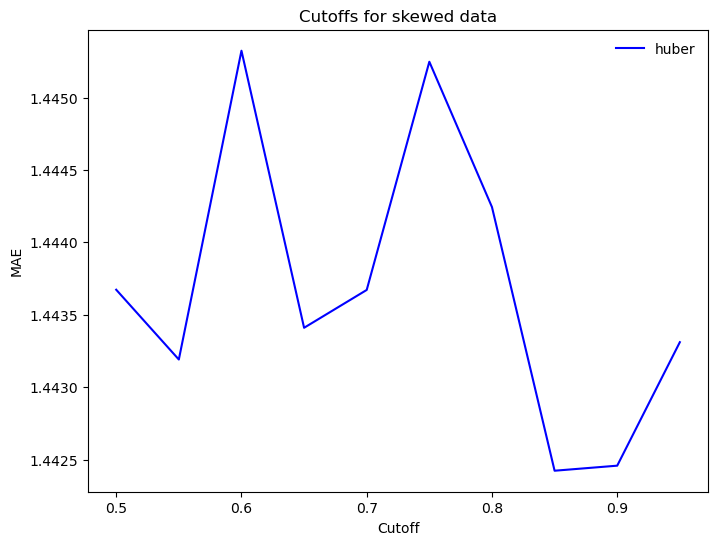

In [623]:
# Graph for different cutoffs
plt.figure(figsize=(8,6))

#plt.plot(cutoffs, maes_lr, label= 'Epsilon Insensitive', c = 'orange')
plt.plot(cutoffs, maes_h, label = 'huber', c = 'blue')
#plt.plot(maes_h, label='huber', c = 'blue')
plt.legend(frameon=False)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel("Cutoff")
plt.ylabel("MAE")
plt.title("Cutoffs for skewed data")

plt.show()

In [ ]:
Takeaways: .9 is still a reasonable cutoff, this is a better clustering cutoff

# Takeaways and Conclusion
Let us use a skew cutoff of .9, cluster cutoffs of 1 and 9, and 'huber' loss

In [628]:
# Get stas for best models (baseline and huber with .9 and 1,9)
mae_1 = X_val.mae_t.mean()
print(mae_1)


V = X[['az_t_pred', 'ze_t_pred', 'num_clusters','mse_cat','per_x', 'per_y', 'per_z']]
V['x_skew'] = [(val > cutoff) for val in V.per_x]
V['y_skew'] = [(val > cutoff) for val in V.per_y]
V['z_skew'] = [(val > cutoff) for val in V.per_z]
V['low_cluster'] = [(c < 2) for c in V.num_clusters]
V['high_cluster'] = [(c > 9) for c in V.num_clusters]
V.replace({False: 0, True: 1}, inplace=True)

V_train, V_val, y_train, y_val = train_test_split(V, y, 
                                                             shuffle = True,
                                                             random_state = 134, 
                                                             test_size = .25)
feature = ['az_t_pred', 'ze_t_pred', 'x_skew', 'y_skew', 'z_skew', 'mse_cat', 'low_cluster', 'high_cluster']
mae_h = run_sgd(V_train, y_train, feature, 'huber')
print(mae_h)

1.2134628158840939


C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\701930753.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['x_skew'] = [(val > cutoff) for val in V.per_x]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\701930753.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V['y_skew'] = [(val > cutoff) for val in V.per_y]
C:\Users\k_vsl\AppData\Local\Temp\ipykernel_15432\701930753.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

1.4433933677776931
